In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
# reading train data
train_data = pd.read_json("./data/train.json")

In [3]:
# converting date time
train_data['time'] = pd.to_datetime(train_data['timestamp'])
train_data = train_data.set_index('time')

In [4]:
# removing unnecessary columns
train_data.drop(['reportingGroup','locationName','unit'], axis = 1,inplace=True)

In [5]:
# number of training samples in the data
train_data.shape[0]

1089

In [6]:
# expnding time to year, month and day
train_data["year"] = train_data["timestamp"].dt.strftime('%Y').astype("int")
train_data["month"] = train_data["timestamp"].dt.strftime('%m').astype("int")
train_data["day"] = train_data["timestamp"].dt.strftime('%d').astype("int")

In [7]:
train_data.drop('timestamp',axis = 1, inplace= True)

In [8]:
# preview the data
train_data.head()

,value,year,month,day
time,,,,
2019-01-08,0.00,2019,1,8
2019-01-09,0.00,2019,1,9
2019-01-10,0.00,2019,1,10
2019-01-11,20.10,2019,1,11
2019-01-12,30.56,2019,1,12


<AxesSubplot:xlabel='time'>

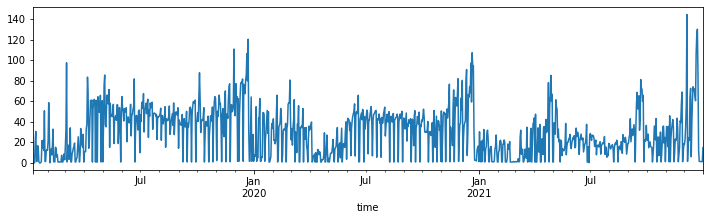

In [9]:
# visualize the data date vs value

train_data.value.plot(figsize=(12,3))


In [10]:
def select_features(df,col_names):
    return df[col_names]

In [11]:
# Create the feature and label vectors
X = select_features(train_data,['year','month','day'])
# value is the energy consumption that we need to predict
y = train_data['value']

In [12]:
from sklearn.model_selection import train_test_split 


# Split the dataset into a training set and a test set like:
# X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
# Fitting a linear regression model
# Predicting label values based on features and calculate the training error

def train_model(x_tr, y_tr):
    
    regr = LinearRegression()
    regr.fit(x_tr,y_tr)

    y_pred = regr.predict(x_tr)   
    tr_error = mse(y_tr,y_pred)


    print('The training error is: ', tr_error)    # print the training error
    print("w1 = ", regr.coef_)   # print the learnt w1
    print("w0 = ",regr.intercept_) # print the learnt w0
    
    return regr,tr_error

In [14]:
# The model performance is poor with current features
train_model(X_train,y_train)

The training error is:  406.27955041975815
w1 =  [-7.57764748  2.6236124  -0.03978154]
w0 =  15321.4615115911


(LinearRegression(), 406.27955041975815)

#### Feature engineering of lag values

In [15]:

# We are trying adding previous day's energy consumption (as lag_1_value column) as a new feature to the data

def get_lag(df,lag=1):
    
    return df['value'].shift(lag).fillna(0)

In [16]:
train_data = train_data.sort_index()
train_data['lag_1_value'] = get_lag(train_data)


<AxesSubplot:xlabel='value', ylabel='lag_1_value'>

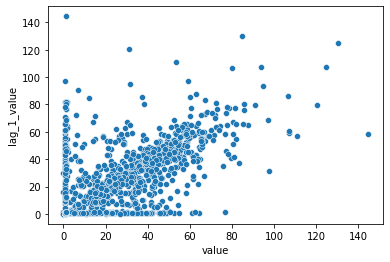

In [17]:
# Visualizing previous days energy consumption with value
sns.scatterplot(x="value",y="lag_1_value",data=train_data)
# as you can see there is some linear relationship between previous energy consumption and current day's
# energy consumption

In [18]:
# checking the correlation
train_data.corr()

,value,year,month,day,lag_1_value
value,1.000000,-0.258338,0.366050,-0.015913,0.502360
year,-0.258338,1.000000,-0.012777,-0.010613,-0.256751
month,0.366050,-0.012777,1.000000,-0.003704,0.371455
day,-0.015913,-0.010613,-0.003704,1.000000,-0.016984
lag_1_value,0.502360,-0.256751,0.371455,-0.016984,1.000000


In [19]:
# building model with added feature lag_1_value
X = select_features(train_data,['year','month','day','lag_1_value'])
y = train_data['value']

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
# There is no much improvement to the model still
train_model(X_train,y_train)

The training error is:  330.85681918861064
w1 =  [-4.45996585  1.46300481  0.00461508  0.43842243]
w0 =  9016.945937617918


(LinearRegression(), 330.85681918861064)

#### Adding rolling mean as a feature

In [22]:
# it might be a good idea to add previous n days average consumption as a new feature,
# currently previous 2 days average is calculated as it gives good performance 
# and stored as mov_avg_3_day column
def move_avg(df,days = 3):
    
    return df['value'].rolling(days).mean().fillna(0)

In [23]:
# moving average of three days
train_data['mov_avg_2_day'] = move_avg(train_data,2)

<AxesSubplot:xlabel='value', ylabel='mov_avg_2_day'>

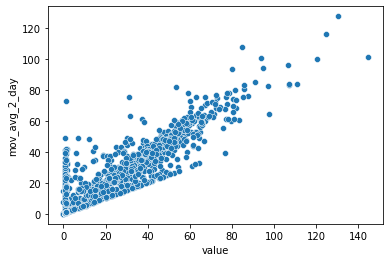

In [24]:
# Visualizing previous 2 days energy consumption average with value
sns.scatterplot(x="value",y="mov_avg_2_day",data=train_data)
# previous 2 days energy consumption average seems to have a positive correlation with energy consumption
# this might be a good feature for our model

In [25]:
# checking correlation again
train_data.corr()
# as you can see there is 0.86 correlation which is higher

,value,year,month,day,lag_1_value,mov_avg_2_day
value,1.000000,-0.258338,0.366050,-0.015913,0.502360,0.866621
year,-0.258338,1.000000,-0.012777,-0.010613,-0.256751,-0.297153
month,0.366050,-0.012777,1.000000,-0.003704,0.371455,0.425465
day,-0.015913,-0.010613,-0.003704,1.000000,-0.016984,-0.018978
lag_1_value,0.502360,-0.256751,0.371455,-0.016984,1.000000,0.866791
mov_avg_2_day,0.866621,-0.297153,0.425465,-0.018978,0.866791,1.000000


In [27]:
# feature 
X = select_features(train_data,['year','month','day','lag_1_value', 'mov_avg_2_day'])
y = train_data['value']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

reg_model,tr_error = train_model(X_train, y_train)
# this model seems to be a good model for our use case

The training error is:  4.637500782103636e-28
w1 =  [ 4.87579229e-15 -9.58396038e-16  5.11225914e-16 -1.00000000e+00
  2.00000000e+00]
w0 =  -9.837464176598587e-12


In [28]:
# validating the best model 
y_pred = reg_model.predict(X_val)
val_error = mse(y_val, y_pred)

In [29]:
print('The test error is: ', val_error)    # print the validation error
# the model seems to have a good fit in terms of training and validation error.

The test error is:  4.731332487049785e-28


In [30]:
# as we are now clear with feature selection
# we need to focus on making sure our model is performing well on
# most of the dataset
# hence we are using k-fold validation with the features consustructed


In [32]:
from sklearn.model_selection import KFold

kfold = KFold(5)
# we train on each fold of X_train and we hold X_test as our test test
data = X_train.to_numpy()
Y = y_train.to_numpy()
i=0

avg_train = []
avg_val = []
avg_test = []

for train, test in kfold.split(data):
    print(f"______________KFOLD:{i+1}_______________")
    x_train = data[train]
    y_t = Y[train]
    x_test = data[test]
    y_v = Y[test]
    k_reg_model , tr_error = train_model(x_train,y_t)
    avg_train.append(tr_error)
    i+=1
    y_pred = k_reg_model.predict(x_test)
    val_error = mse(y_v,y_pred)
    avg_val.append(val_error)
    print('The validation error is: ', val_error) 
    y_pred = k_reg_model.predict(X_val)
    test_error = mse(y_val,y_pred)
    avg_test.append(test_error)
    print('Test error for the split is : ',test_error)
print(f"Average training error {np.mean(avg_train)}")
print(f"Average validation error {np.mean(avg_val)}")
print(f"Average test error {np.mean(avg_test)}")

______________KFOLD:1_______________
The training error is:  3.940719812141861e-28
w1 =  [ 7.65084775e-16 -1.47648772e-15  3.53210326e-16 -1.00000000e+00
  2.00000000e+00]
w0 =  -1.5241141682054149e-12
The validation error is:  3.6071324065450385e-28
Test error for the split is :  3.8465899148093065e-28
______________KFOLD:2_______________
The training error is:  6.017520184898926e-28
w1 =  [-3.64933133e-15 -1.23631418e-15  2.39610805e-16 -1.00000000e+00
  2.00000000e+00]
w0 =  7.396749879262643e-12
The validation error is:  5.9431846482628535e-28
Test error for the split is :  5.45455895363097e-28
______________KFOLD:3_______________
The training error is:  4.0348908076162444e-28
w1 =  [ 8.27730713e-15 -1.93341318e-17  6.60413371e-17 -1.00000000e+00
  2.00000000e+00]
w0 =  -1.6715517858756357e-11
The validation error is:  5.516651039689696e-28
Test error for the split is :  3.6323669989178696e-28
______________KFOLD:4_______________
The training error is:  5.710200451809087e-27
w1 =  

In [33]:
# from the above K-fold analysis , the first and second fold seems to be a good model to choose
# for time series based problems, it is usual to use k-fold cross validation and 
# choose the best model out of it. Random splitting will not give a good model and you can 
# see for the random splitting of training and validation set , the model was a lower performance 
# compared to the k-fold cross validations

### Lasso Regression

In [34]:
def lasso_regressor(x_tr, y_tr):
    model = linear_model.Lasso(alpha=0.0001,max_iter=500).fit(x_tr, y_tr)
    y_predict = model.predict(x_tr)
    tr_error = mse(y_tr,y_predict)


    print('The training error for Lasso regressor is: ', tr_error)    # print the training error
    return model,tr_error

In [35]:
lasso_model,tr_er = lasso_regressor(X_train,y_train)

The training error for Lasso regressor is:  4.577612387374193e-05


In [36]:
# validating the best model 
y_pred = lasso_model.predict(X_val)
val_error = mse(y_val, y_pred)

In [37]:
print('The test error is: ', val_error)    # print the validation error
# the model seems to have a good fit in terms of training and validation error.

The test error is:  6.629736584402331e-05


In [38]:
i=0

avg_train = []
avg_val = []
avg_test = []

for train, test in kfold.split(data):
    print(f"______________KFOLD:{i+1}_______________")
    x_train = data[train]
    y_t = Y[train]
    x_test = data[test]
    y_v = Y[test]
    k_lasso_model,tr_error = lasso_regressor(x_train,y_t)
    avg_train.append(tr_error)
    i+=1
    y_pred = k_lasso_model.predict(x_test)
    val_error = mse(y_v,y_pred)
    avg_val.append(val_error)
    print('The valiation error is: ', val_error) 
    y_pred = k_lasso_model.predict(X_val)
    test_error = mse(y_val,y_pred)
    avg_test.append(test_error)
    print('The test error is: ', test_error)
print(f"Average training error {np.mean(avg_train)}")
print(f"Average validation error {np.mean(avg_val)}")
print(f"Average test error {np.mean(avg_test)}")

______________KFOLD:1_______________
The training error for Lasso regressor is:  4.287115824984893e-05
The valiation error is:  4.182832417547397e-05
The test error is:  6.171594623900221e-05
______________KFOLD:2_______________
The training error for Lasso regressor is:  3.6195303912758506e-05
The valiation error is:  4.44406761329087e-05
The test error is:  5.479736712787742e-05
______________KFOLD:3_______________
The training error for Lasso regressor is:  5.944310371273692e-05
The valiation error is:  9.394813555580005e-05
The test error is:  9.591451540326067e-05
______________KFOLD:4_______________
The training error for Lasso regressor is:  3.026926272150609e-05
The valiation error is:  2.2493044663814368e-05
The test error is:  4.154538118379413e-05
______________KFOLD:5_______________
The training error for Lasso regressor is:  3.717639391478788e-05
The valiation error is:  2.5542106222999262e-05
The test error is:  5.0569018551362916e-05
Average training error 4.119104450232

### Ridge regression

In [39]:
def ridge_regressor(x_tr, y_tr):
    model = linear_model.Ridge(alpha=0.001,max_iter=500).fit(x_tr, y_tr)
    y_predict = model.predict(x_tr)
    tr_error = mse(y_tr,y_predict)


    print('The training error for Ridge regressor is: ', tr_error)    # print the training error
    return model,tr_error

In [40]:
ridge_model,tr_error = ridge_regressor(X_train,y_train)

The training error for Ridge regressor is:  1.730050157620543e-13


In [41]:
# validating the model 
y_pred = ridge_model.predict(X_val)
val_error = mse(y_val, y_pred)

In [43]:
print('The test error is: ', val_error)    # print the validation error
# the model seems to have a good fit in terms of training and validation error.

The test error is:  2.330469965226065e-13


In [44]:
i=0

avg_train = []
avg_val = []
avg_test = []


for train, test in kfold.split(data):
    print(f"______________KFOLD:{i+1}_______________")
    x_train = data[train]
    y_t = Y[train]
    x_test = data[test]
    y_v = Y[test]
    k_ridge_model,tr_error = ridge_regressor(x_train,y_t)
    avg_train.append(tr_error)
    i+=1
    y_pred = k_ridge_model.predict(x_test)
    val_error = mse(y_v,y_pred)
    avg_val.append(val_error)
    print('The valiation error is: ', val_error) 
    y_pred = k_ridge_model.predict(X_val)
    test_error = mse(y_val,y_pred)
    avg_test.append(test_error)
    print('The test error is: ', test_error) 
print(f"Average training error {np.mean(avg_train)}")
print(f"Average validation error {np.mean(avg_val)}")
print(f"Average test error {np.mean(avg_test)}")

______________KFOLD:1_______________
The training error for Ridge regressor is:  2.689111486380063e-13
The valiation error is:  2.6323720237100336e-13
The test error is:  3.59883863215799e-13
______________KFOLD:2_______________
The training error for Ridge regressor is:  2.862477254759837e-13
The valiation error is:  3.7097679339586827e-13
The test error is:  4.0655884296444653e-13
______________KFOLD:3_______________
The training error for Ridge regressor is:  2.9314038486092733e-13
The valiation error is:  4.268184211118198e-13
The test error is:  4.3946644842117784e-13
______________KFOLD:4_______________
The training error for Ridge regressor is:  2.5883506872674864e-13
The valiation error is:  2.070434190807234e-13
The test error is:  3.3054110694177675e-13
______________KFOLD:5_______________
The training error for Ridge regressor is:  2.525195910234718e-13
The valiation error is:  1.731405253599478e-13
The test error is:  3.174135968686088e-13
Average training error 2.719307837